# Clustering Routine

This Jupyter Notebook can be ran after the initial crawling with the *crawl.py* python script to categorize a big number of news articles by their topics. The duration of the Jupyter Notebook processing time may vary depending on your dataset size. You can estimate at least a few hours for datasets bigger than 50 000 articles.

# Routine Of The Jupyter Notebook

This algorithm can be structured into the following main components:

1. Load crawled dataset from the folder *./crawl_json/*.
2. Preprocessing.
3. Visualize the data with wordclouds.
4. LDA Clustering. Find the optimal amount of clusters with the coherence score.
5. Visualize the optimal topic clusters with LDAvis.
6. Sort all documents into a directory *./clustered_json/* to represent their cluster topics.


# Open Data From JSON
First we have to load our previously cralwed dataset into memory.

In [1]:
import pandas as pd
import os
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [3]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 268122


# Preprocessing 

We will now continue with preparing the data for the actual clustering. Therefore we are lemmatizing all strings and removing all words that aren't nouns.

In [4]:
import re

In [5]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [6]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

estimated_minutes = amount_of_articles * 0.000217

print(f'Tokenizing all articles. This may take a while. (Estimate: ~{ round(estimated_minutes, 2) } minutes)')
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continue with lemmatization & noun extraction.")


Tokenizing all articles. This may take a while. (Estimate: ~58.18 minutes)
Finished tokenizing all articles. Continue with lemmatization & noun extraction.


In [9]:
print("Lemmatization & noun extraction is running...")
for element in tqdm(df["tokenized_words"]):
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

print("Finished lemmatization & noun extraction.")
df["maintext_nouns"] = nouns

Lemmatization & noun extraction is running...


  1%|          | 2296/268122 [02:12<3:31:24, 20.96it/s]

In [ ]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

The following word clouds will give you a general idea about how each step in preprocessing improves the quality of the dataset for our use case. The bigger a word is shown, the more frequent is its existence in our dataset. 

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

This word cloud includes all words of the articles without major filtering.

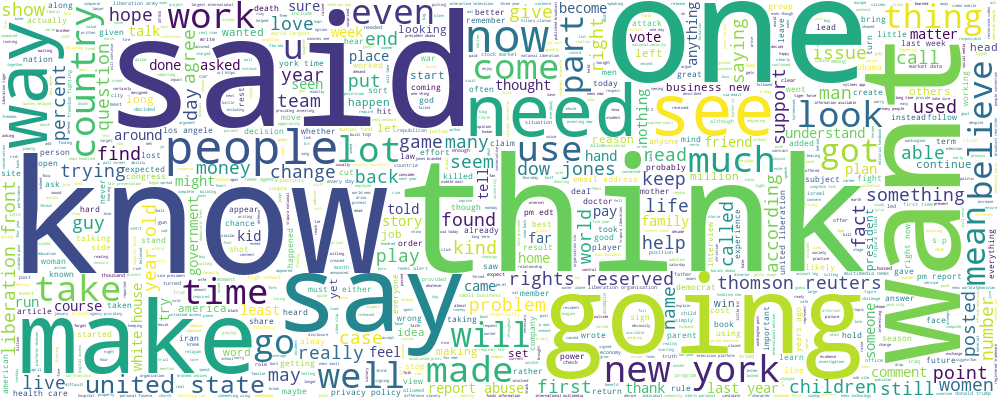

In [ ]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

This word cloud shows you only the nouns of the acticles.

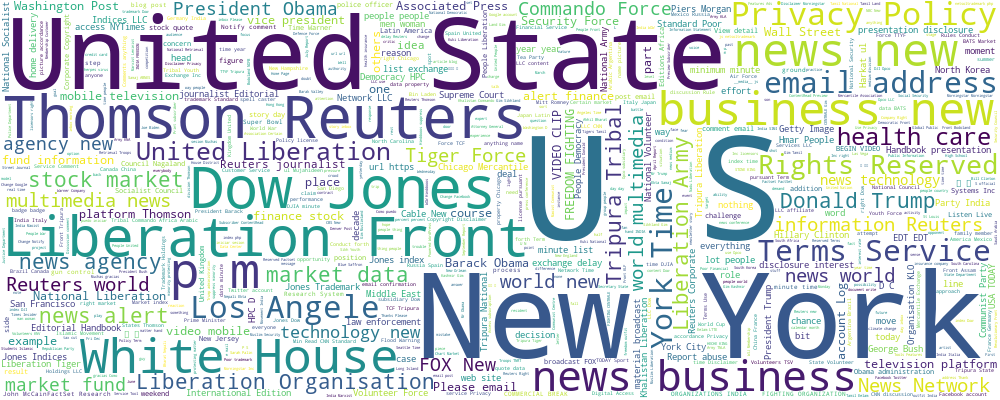

In [ ]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

We will continue preparing our data for the LDA clustering by removing predefined stopwords (extended by *./stopwords.json*) and filtering out unwanted characters.

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


In [ ]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [ ]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [ ]:
#Remove non alphanumeric words
def remove_non_alphanumeric(texts):
    return [[word for word in list if word.isalnum()] for list in texts]

In [ ]:
def remove_non_ASCII(lists):
    for list in lists:
        for i, string in enumerate(list):
            if string.isascii():
                continue
            else:
                list.pop(i)
    return lists

In [ ]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
maintext_ready = remove_non_ASCII(maintext_ready)
df["maintext_ready"]  = maintext_ready

In [ ]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,..."


# Wordcloud of the ready-to-cluster articles

This is the word cloud of the dataset which we will actually apply out LDA clustering on.

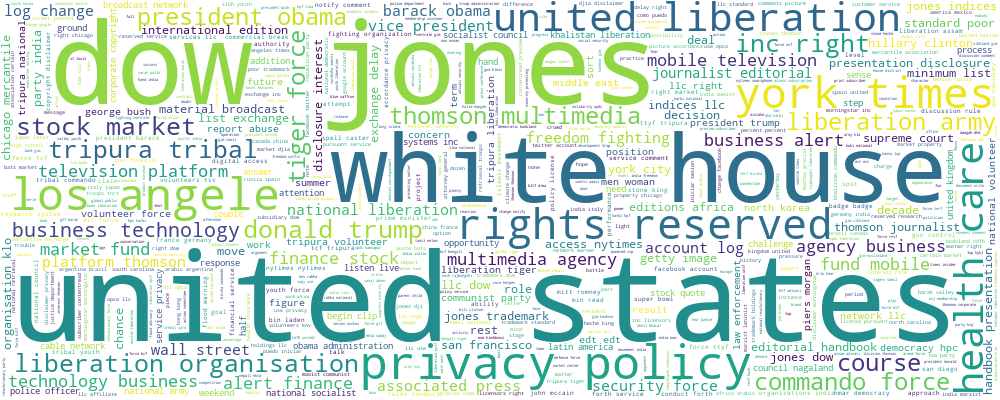

In [ ]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

Creating a corpus is needed to have data that is understandable to gensim. This will be given to the LDA algorithm to perform the clustering.

In [ ]:
import gensim.corpora as corpora

In [ ]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [ ]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (..."


# Build a LDA model & calculate Coherence Score

The following code is going through a prefined range of topic amounts to check which clustering approach suits the dataset best. Each iteration inlcludes the clustering of all articles and the calculation of the coherence score. Once a certain coherence is reached, the algorithm continues with taking the best possible clusters.
We implement this break within the algorithm to avoid unneccasary splitting of clusters.

In [ ]:
from pprint import pprint   #pretty printing
from gensim.models import CoherenceModel

In [ ]:
topic_amount_start = 10     #specify where to start generating clusters
topic_amount_end = 50      #specify the maximum amount of clusters (will need more RAM during calculations)
iteration_interval = 1      #the interval in which coherences and lda models should be calculated (for example: iteration_interval = 5 => 10,15,20,25,... clusters). For best results choose 1 (but it will take longer then)
desired_coherence = 0.6     #the minimum coherence. if set too high, the algorithm will continue with the clusters with highest coherence score between topic_amount_start and topic_amound_end

The following snipped is responsible for the actual LDA clustering. It will determine the coherence score each iteration and choose the best possible clusters based on the coherence score.
If `desired_coherence` is met, the algorithm will break to avoid unneccasary high amounts of clusters.

In [ ]:
amount_of_topics = 0
best_coherence = 0
best_ld_model = 0

coherences = []
lda_models = []

print(f"Calculating the optimal amount of clusters inbetween {topic_amount_start} and {topic_amount_end}.")

#Find the best possible coherence value inbetween the given min and max amount of articles. Continue with the best lda model found.
for amount_of_topics in range(topic_amount_start, topic_amount_end, iteration_interval):   
    lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics, alpha=0.1, eta=0.01)   #build the LDA model

    cm = CoherenceModel(model=lda_model, texts=df["maintext_ready"].tolist(), dictionary=word_dictionary, coherence='c_v')     #calculate coherence
    coherence = cm.get_coherence()
    print(f"Coherence with {amount_of_topics} topics: ", coherence)

    coherences.append(coherence)
    lda_models.append(lda_model)

    if (coherence > desired_coherence):
        best_coherence = coherence
        best_ld_model = lda_model
        print("Reached the desired coherence score!")
        break;      # desired coherence score met



Calculating the optimal amount of clusters inbetween 10 and 150.
Coherence with 10 topics:  0.5235933140130336
Coherence with 11 topics:  0.5517809816706765
Coherence with 12 topics:  0.5641993095344154
Coherence with 13 topics:  0.48227154850154236
Coherence with 14 topics:  0.5363269559825697
Coherence with 15 topics:  0.48847334796790326
Coherence with 16 topics:  0.4954804502445641
Coherence with 17 topics:  0.5030557271433951
Coherence with 18 topics:  0.48863251345357994
Coherence with 19 topics:  0.49147049445359753
Coherence with 20 topics:  0.4711511189118795
Coherence with 21 topics:  0.48071474128675185
Coherence with 22 topics:  0.510074743545818
Coherence with 23 topics:  0.4986727116496277
Coherence with 24 topics:  0.516981772007851
Coherence with 25 topics:  0.5117010368748135
Coherence with 26 topics:  0.45581494556645513
Coherence with 27 topics:  0.49953705736314624
Coherence with 28 topics:  0.46183132979881536
Coherence with 29 topics:  0.5242035856119478
Coherence

OSError: [Errno 22] Invalid argument

In [ ]:
#Determine the best coherence of all if the desired_coherence wasnt matched
if (best_coherence == 0):
    print("Desired coherence not reached. Please adjust the desired_coherence paramter to a more realistic value. Continuing with the best possible coherence.")
    max_coherence = max(coherences)
    max_index = coherences.index(max_coherence)
    best_lda_model = lda_models[max_index]

amount_of_topics = len(best_ld_model.get_topics())
print("Best coherence: " + str(max_coherence) + ", Amount of clusters: " + str(amount_of_topics))

14


NameError: name 'max_index' is not defined

In [ ]:
print(len(lda_model[corpus]))

In [ ]:
import matplotlib.pyplot as plt

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


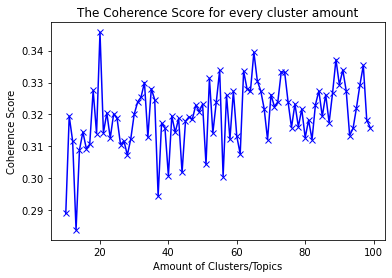

In [ ]:
# A graph about how the coherence changes depending on the amount of clusters
plt.plot(range(topic_amount_start, topic_amount_end, iteration_interval), coherences, 'bx-')
plt.xlabel('Amount of Clusters/Topics')
plt.ylabel('Coherence Score')
plt.title('The Coherence Score for every cluster amount')
plt.show()

# Displaying the LDA model

This is the built LDA model. The first number represents the cluster ID. The other part shows you the propablity of words in the specific topic.

In [ ]:
pprint(best_lda_model.print_topics())
articles_lda = best_lda_model[corpus]

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.008*"gun" + 0.006*"force" + 0.004*"liberation" + 0.004*"right" + '
  '0.003*"law" + 0.003*"child" + 0.003*"war" + 0.003*"united" + '
  '0.003*"tripura" + 0.003*"national"'),
 (1,
  '0.006*"india" + 0.004*"child" + 0.004*"team" + 0.003*"school" + '
  '0.003*"season" + 0.003*"player" + 0.003*"work" + 0.003*"woman" + '
  '0.003*"cbd" + 0.003*"trump"'),
 (2,
  '0.009*"force" + 0.008*"national" + 0.007*"liberation" + 0.007*"tripura" + '
  '0.004*"india" + 0.004*"gun" + 0.004*"united" + 0.004*"right" + 0.004*"game" '
  '+ 0.004*"army"'),
 (3,
  '0.004*"trump" + 0.003*"woman" + 0.003*"force" + 0.003*"man" + 0.003*"money" '
  '+ 0.003*"god" + 0.003*"california" + 0.003*"obama" + 0.003*"child" + '
  '0.002*"work"'),
 (4,
  '0.005*"sesion" + 0.005*"puedo" + 0.005*"gracias" + 0.005*"como" + '
  '0.005*"iniciar" + 0.004*"muchas" + 0.004*"woman" + 0.003*"service" + '
  '0.003*"child" + 0.003*"money"'),
 (5,
  '0.007*"obama" + 0.006*"president" + 0.004*"war" + 0.003*"money" + '
  '0.003*"g

# Visualize the LDA model

This visualization is interactable and helps you identifying the quality of the LDA clustering by hand.

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.025035  0.014328       1        1  13.659172
13    -0.036281 -0.026526       2        1  11.040130
12     0.099870 -0.004979       3        1   6.644348
19     0.004387  0.005071       4        1   6.310954
16    -0.014951  0.001457       5        1   6.259672
3     -0.001807  0.011886       6        1   5.988197
1     -0.021853 -0.008427       7        1   4.930654
4     -0.026004  0.032947       8        1   4.908459
11    -0.002411  0.009168       9        1   4.789997
14    -0.016808 -0.013779      10        1   4.735722
18    -0.017091 -0.013306      11        1   4.665083
9     -0.024294 -0.006855      12        1   4.352213
0      0.016879  0.003180      13        1   4.272047
8     -0.005897 -0.004025      14        1   3.599907
7     -0.013955 -0.005019      15        1   3.503878
10    -0.004112 -0.000897      16        1   3.169345
6      0.016653 -0.007767      17        1   2.454017
17     0.022374  0.019768      18        1   2.042468
15     0.006640  0.005622      19        1   1.579120
2      0.043698 -0.011847      20        1   1.094618, topic_info=             Term          Freq         Total Category  logprob  loglift
823    liberation  45698.000000  45698.000000  Default  30.0000  30.0000
1275        force  62728.000000  62728.000000  Default  29.0000  29.0000
36563     tripura  38717.000000  38717.000000  Default  28.0000  28.0000
871      national  41254.000000  41254.000000  Default  27.0000  27.0000
8389          ufc  21450.000000  21450.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
138        player    336.975176  25512.694894  Topic20  -6.3610   0.1878
953        school    356.421845  37372.077364  Topic20  -6.3049  -0.1378
1309   government    358.008092  41828.401268  Topic20  -6.3004  -0.2460
265           god    341.891610  32992.680140  Topic20  -6.3465  -0.0548
172          team    342.467890  41998.436654  Topic20  -6.3448  -0.2944

[2007 rows x 6 columns], token_table=        Topic      Freq          Term
term                                 
167156      1  0.996146       abeille
167157      1  0.927045  abeillephone
137456      8  0.629403        abovet
140943      5  1.047186    abrahamian
272130      4  0.834764    abromovich
...       ...       ...           ...
44036      16  0.010888            วน
44036      17  0.079698            วน
44036      18  0.005444            วน
44036      19  0.010234            วน
44036      20  0.018074            วน

[10487 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 14, 13, 20, 17, 4, 2, 5, 12, 15, 19, 10, 1, 9, 8, 11, 7, 18, 16, 3])

# Store Cluster IDs to dataframe

To be able to correctly sort all articles into a floder hierachy wee need to store each articles cluster id into the dataframe.

In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = best_lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(11, '0.004*"woman" + 0.004*"man" + 0.004*"right" + 0.004*"god" + 0.004*"child"')
(19, '0.004*"president" + 0.004*"school" + 0.004*"trump" + 0.004*"india" + 0.003*"force"')
(14, '0.006*"game" + 0.004*"season" + 0.003*"obama" + 0.003*"child" + 0.003*"service"')
(17, '0.006*"force" + 0.005*"muchas" + 0.005*"liberation" + 0.005*"gracias" + 0.005*"iniciar"')
(0, '0.008*"gun" + 0.006*"force" + 0.004*"liberation" + 0.004*"right" + 0.003*"law"')
(16, '0.004*"ufc" + 0.004*"herpes" + 0.004*"obama" + 0.003*"president" + 0.003*"god"')
(2, '0.009*"force" + 0.008*"national" + 0.007*"liberation" + 0.007*"tripura" + 0.004*"india"')
(18, '0.004*"game" + 0.004*"child" + 0.003*"team" + 0.003*"woman" + 0.003*"man"')
(6, '0.005*"woman" + 0.005*"force" + 0.005*"liberation" + 0.004*"school" + 0.004*"obama"')
(10, '0.004*"child" + 0.003*"force" + 0.003*"trump" + 0.003*"health" + 0.003*"california"')


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for row in tqdm(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_num = row[0][0]
    prop_topic = row[0][1]

    wp = best_lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    topic_list.append(int(topic_num))
    topic_percentage_list.append(round(prop_topic,5))
    topic_keywords_list.append(topic_keywords)


df["LDA_ID"] = topic_list    ##the id of the topic
df["LDA_topic_percentage"] = topic_percentage_list  #how well the topic fits to this specifc article
df["LDA_topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 41103/41103 [17:13<00:00, 39.79it/s]


In [ ]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,LDA_ID,LDA_topic_percentage,LDA_topic_keywords
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...",11,0.95169,"woman, man, right, god, child, india, force, g..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...",15,0.39784,"obama, force, child, america, right, war, nati..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (...",7,0.99530,"ufc, team, game, season, city, mma, force, pre..."


# Output LDA clustering to json files


In [ ]:
df = df.drop(columns=["maintext_prepro", "tokenized_articles", "maintext_nouns", "corpus", "id"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.

filtered_maintext = [ " ".join(row["maintext_ready"]) for index, row in df.iterrows() ]   

df["filtered_maintext"] = filtered_maintext

df = df.drop(columns=["maintext_ready", "tokenized_words"])

df.head()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,LDA_ID,LDA_topic_percentage,LDA_topic_keywords,filtered_maintext
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,11,0.95169,"woman, man, right, god, child, india, force, g...",neighbors forums general discussion talk denve...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,15,0.39784,"obama, force, child, america, right, war, nati...",brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,7,0.99530,"ufc, team, game, season, city, mma, force, pre...",update global public square show fareed take g...
3,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:08:18","Skip to main content Published: Jan 23, 2019 B...",en,jobs.washingtonpost.com,"Skip to main content Published: Jan 23, 2019By...",How Much Salary Negotiation Is Too Much?,https://jobs.washingtonpost.com/article/how-mu...,4,0.49617,"sesion, puedo, gracias, como, iniciar, muchas,...",skip arden davidson salary balancing act price...
4,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:30",One of artist Shepard Fairey's next projects c...,en,latimesblogs.latimes.com,One of artist Shepard Fairey's next projects ...,Shepard Fairey puts services up for auction | ...,https://latimesblogs.latimes.com/culturemonste...,19,0.76043,"president, school, trump, india, force, policy...",artist shepard fairey project portrait los ang...


# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [ ]:
import ujson

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.reset_index(drop=True,inplace=True)

for cluster_id, data in df.groupby(df.LDA_ID):
    item = data.LDA_topic_keywords.iloc[0].split(",")
    with open(f'./lda_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}.json', 'w', encoding='utf-8') as f:
        f.write(ujson.dumps(data.to_dict('index'), indent=4, ensure_ascii=False, escape_forward_slashes=False))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
